In [2]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
import torch

from datetime import datetime
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE.doe_lhs import lhs
from scipy.interpolate import griddata
from scipy.optimize import minimize
from torch import nn


pi = torch.tensor(np.pi)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Continuous Time Model of solution of Burguers' Equation $u(t, x)$

In [3]:
data = scipy.io.loadmat(os.path.join('.', 'Data', 'burgers_shock.mat'))

In [4]:
N_u = 100
N_f = 10000

In [5]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x, t)

# (x, t)
X_star = np.c_[X.flatten()[:, None], T.flatten()[:, None]]
u_star = Exact.flatten()[:, None]

# Domain bounds (x, t)
lb = X_star.min(0)
ub = X_star.max(0)  

In [6]:
xx1 = np.c_[X[0:1,:].T, T[0:1,:].T]
uu1 = Exact[0:1,:].T
xx2 = np.c_[X[:,0:1], T[:,0:1]]
uu2 = Exact[:,0:1]
xx3 = np.c_[X[:,-1:], T[:,-1:]]
uu3 = Exact[:,-1:]

X_u_train = np.r_[xx1, xx2, xx3]
X_f_train_ = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.r_[X_f_train_, X_u_train]

u_train = np.r_[uu1, uu2, uu3]

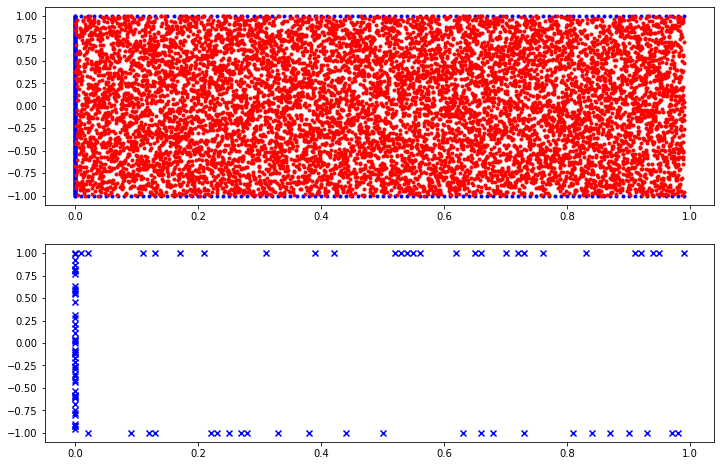

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.scatter(X_u_train[:, 1], X_u_train[:, 0], c='blue', marker='.')
ax1.scatter(X_f_train_[:, 1], X_f_train_[:, 0], c='red', marker='.')

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

ax2.scatter(X_u_train[:, 1], X_u_train[:, 0], c='blue', marker='x')

plt.show()

## Using pytorch optimizers

In [89]:
def model_size(model):
    num_params = 0
    for params in neural_net.parameters():
        try: num_params += torch.multiply(*params.size())
        except: num_params += params.size()[0]
    return num_params
    

class NeuralNet(nn.Module):
    def __init__(self, layers, ub, lb):
        super(NeuralNet, self).__init__()
        input_layer = [nn.Linear(2, layers[0]), nn.Tanh()]
        hidden_layers = []
        for i in range(len(layers[:-1])):
            hidden_layers.append(nn.Linear(layers[i], layers[i+1]))
            hidden_layers.append(nn.Tanh())
        output_layer = nn.Linear(layers[-1], 1)
        self.fcnn = nn.Sequential(*input_layer, *hidden_layers, output_layer)
        
    def forward(self, x):
        y_hat = self.fcnn(x)
        return y_hat
    

layers = [20, 20, 20, 20, 20, 20, 20, 20]
neural_net = NeuralNet(layers, ub, lb)
print(f'Number of model parameters: {int(model_size(neural_net))}')
print(neural_net)

Number of model parameters: 3021
NeuralNet(
  (fcnn): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [107]:
def net_u(x, t):
    u = neural_net(torch.cat([x, t], 1))
    return u

def net_f(x, t):
    u = net_u(x, t)
    u_x = torch.autograd.grad(u, [x], grad_outputs=torch.ones_like(u), retain_graph=True)[0]
    u_t = torch.autograd.grad(u, [t], grad_outputs=torch.ones_like(u))[0]
    
    print(u_x)
    
    u_xx = torch.autograd.grad(u_x, [x], grad_outputs=torch.ones_like(u_x))[0]
    print(u_xx)
    # f = u_t + u * u_x - (0.01 / pi) * u_xx
    # return f


x_u = torch.tensor(X_u_train[:, [0]], dtype=torch.float, requires_grad=True)
t_u = torch.tensor(X_u_train[:, [1]], dtype=torch.float, requires_grad=True)

x_f = torch.tensor(X_f_train[:, [0]], dtype=torch.float, requires_grad=True)
t_f = torch.tensor(X_f_train[:, [1]], dtype=torch.float, requires_grad=True)

u = torch.tensor(u_train, dtype=torch.float)

net_f(x_u, t_u)

tensor([[0.0075],
        [0.0054],
        [0.0064],
        [0.0046],
        [0.0038],
        [0.0061],
        [0.0032],
        [0.0077],
        [0.0035],
        [0.0038],
        [0.0072],
        [0.0030],
        [0.0075],
        [0.0040],
        [0.0035],
        [0.0031],
        [0.0070],
        [0.0034],
        [0.0076],
        [0.0072],
        [0.0041],
        [0.0068],
        [0.0069],
        [0.0074],
        [0.0060],
        [0.0061],
        [0.0076],
        [0.0047],
        [0.0059],
        [0.0059],
        [0.0063],
        [0.0029],
        [0.0057],
        [0.0036],
        [0.0053],
        [0.0063],
        [0.0064],
        [0.0029],
        [0.0064],
        [0.0074],
        [0.0057],
        [0.0072],
        [0.0050],
        [0.0028],
        [0.0055],
        [0.0059],
        [0.0055],
        [0.0031],
        [0.0030],
        [0.0038],
        [0.0053],
        [0.0077],
        [0.0063],
        [0.0037],
        [0.0058],
        [0

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [44]:
X_u_train[:, [0]].dtype

dtype('<f8')

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(1, epochs+1), losses)
ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.grid()
plt.show()

## Paper code result

**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  
**Loss**: 2.8863915e-06  

Training time: 205.8400  

**Error u**: 2.734814e-03 (0.002734814)

In [ ]:
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

x_star = tf.convert_to_tensor(X_star[:, [0]], dtype=tf.float32)
t_star = tf.convert_to_tensor(X_star[:, [1]], dtype=tf.float32)

u_hat = net_u(x_star, t_star).numpy()
f_hat = net_f(x_star, t_star).numpy()

error_u = np.linalg.norm(u_star-u_hat, 2) / np.linalg.norm(u_star, 2)
print(f'Error u: {error_u}')  

U_pred = griddata(X_star, u_hat.flatten(), (X, T), method='cubic')


fig, ax = newfig(15, 12)
ax.axis('off')

################## u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1], X_u_train[:, 0], 'kx', label=f'Data ({u_train.shape[0]} points)', markersize=5, clip_on=False)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc='upper right')
ax.set_title('$u(t,x)$', fontsize=10)

plt.show()

In [ ]:
from IPython.display import display, HTML

fig, ax = plt.subplots(figsize=(7, 6))

def animation_func(t):
    error_u = np.linalg.norm(Exact[t, :] - U_pred[t, :], 2) / np.linalg.norm(Exact[t, :], 2)
    ax.clear()
    ax.plot(x, U_pred[t, :], label='Prediction', c='red')
    ax.plot(x, Exact[t, :], label='Exact', c='blue')
    ax.set_xlim((-1., 1.))
    ax.set_ylim((-1.05, 1.05))
    ax.set_title('$t = 0.{}$, $error = {}$'.format(t, np.round(error_u, 4)))
    ax.legend(frameon=False, loc='upper right')
    ax.grid()

anim = FuncAnimation(ax.figure, animation_func, frames=np.arange(1, 100), interval=75)
display(HTML(anim.to_jshtml(default_mode='once')))
plt.close()